## First Neural Network

In [1]:
!pip install tsfresh



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.1/169.1 kB 9.3 MB/s eta 0:00:00


In [2]:

!pip install keras-tuner


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.1 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
import pandas as pd
import numpy as np
from tsfresh import extract_features
from tsfresh.feature_extraction import ComprehensiveFCParameters

# If you need to plot or visualize data later on
import matplotlib.pyplot as plt
import seaborn as sns

# For any data preprocessing or manipulation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Depending on the models you plan to use
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report


## Dataset

In [5]:
fazeli_mitbih_train_df = pd.read_csv('/content/drive/MyDrive/mitbih_train.csv', header=None)

In [22]:
#fazeli_mitbih_test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/mitbih_test.csv', header=None)

In [7]:
column_187 = fazeli_mitbih_train_df.iloc[:, 187]
column_187.value_counts()

0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: 187, dtype: int64

# Bidirectional LSTM Neural Network

Two Layers

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def create_model_LSTM_bidirectional():
    input_shape = (187, 1)  # input shape based on the dataset
    model = Sequential([
        # Wrapping the LSTM layer with Bidirectional
        Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape),
        Dropout(0.1),

        # Adding another Bidirectional LSTM layer
        Bidirectional(LSTM(units=64, return_sequences=False)),
        Dropout(0.1),

        # Dense layer
        Dense(units=150, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # Adjusted for 5 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the bidirectional LSTM model
model_LSTM_bidirectional = create_model_LSTM_bidirectional()

# Now use model_LSTM_bidirectional for training


In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model_LSTM_bidirectional.h5',  # filename to reflect it's the bidirectional LSTM model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Create the bidirectional LSTM model with the best hyperparameters
# 'create_model_LSTM_bidirectional()' function is defined and returns the bidirectional LSTM model
model_LSTM_bidirectional = create_model_LSTM_bidirectional()

# Train the bidirectional LSTM model with the callbacks
history_LSTM_bidirectional = model_LSTM_bidirectional.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs as necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluation on Test Data
test_loss, test_accuracy = model_LSTM_bidirectional.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model_LSTM_bidirectional.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Epoch 1/100
2189/2189 [==============================] - ETA: 0s - loss: 0.3221 - accuracy: 0.9170
Epoch 1: val_loss improved from inf to 0.17689, saving model to best_model_LSTM_bidirectional.h5
2189/2189 [==============================] - 80s 33ms/step - loss: 0.3221 - accuracy: 0.9170 - val_loss: 0.1769 - val_accuracy: 0.9508 - lr: 0.0010
Epoch 2/100
   5/2189 [..............................] - ETA: 1:00 - loss: 0.1799 - accuracy: 0.9563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2189/2189 [==============================] - ETA: 0s - loss: 0.1750 - accuracy: 0.9525
Epoch 2: val_loss improved from 0.17689 to 0.15195, saving model to best_model_LSTM_bidirectional.h5
2189/2189 [==============================] - 68s 31ms/step - loss: 0.1750 - accuracy: 0.9525 - val_loss: 0.1519 - val_accuracy: 0.9587 - lr: 0.0010
Epoch 3/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1398 - accuracy: 0.9618
Epoch 3: val_loss improved from 0.15195 to 0.11292, saving model to best_model_LSTM_bidirectional.h5
2189/2189 [==============================] - 68s 31ms/step - loss: 0.1398 - accuracy: 0.9618 - val_loss: 0.1129 - val_accuracy: 0.9660 - lr: 0.0010
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1225 - accuracy: 0.9663
Epoch 4: val_loss improved from 0.11292 to 0.10153, saving model to best_model_LSTM_bidirectional.h5
2189/2189 [==============================] - 68s 31ms/step - loss: 0.1225 - accuracy: 0.9663 - val_loss: 0.1015 - va

NameError: name 'confusion_matrix' is not defined

bidirectionality with another layer

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def create_model_LSTM_bidirectional_2():
    input_shape = (187, 1)  # input shape based on the dataset
    model = Sequential([
        Bidirectional(LSTM(units=128, return_sequences=True), input_shape=input_shape),
        Dropout(0.1),

        Bidirectional(LSTM(units=64, return_sequences=True)),
        Dropout(0.1),

        Bidirectional(LSTM(units=32, return_sequences=False)),  # Additional layer
        Dropout(0.1),

        Dense(units=150, activation='relu'),
        Dropout(0.3),
        Dense(5, activation='softmax')  # Adjusted for 5 classes
    ])

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the LSTM model with two bidirectional layers
model_LSTM_bidirectional_2 = create_model_LSTM_bidirectional_2()


In [11]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model_LSTM_bidirectional_2.h5',  # Updated filename for the new bidirectional model
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Assuming 'create_model_LSTM_bidirectional_2()' function is defined and returns the bidirectional LSTM model
model_LSTM_bidirectional_2 = create_model_LSTM_bidirectional_2()

# Train the bidirectional LSTM model with the callbacks
history_LSTM_bidirectional_2 = model_LSTM_bidirectional_2.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs as necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluation on Test Data
test_loss, test_accuracy = model_LSTM_bidirectional_2.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model_LSTM_bidirectional_2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Epoch 1/100
2189/2189 [==============================] - ETA: 0s - loss: 0.4754 - accuracy: 0.8748
Epoch 1: val_loss improved from inf to 0.24721, saving model to best_model_LSTM_bidirectional_2.h5
2189/2189 [==============================] - 103s 43ms/step - loss: 0.4754 - accuracy: 0.8748 - val_loss: 0.2472 - val_accuracy: 0.9373 - lr: 0.0010
Epoch 2/100
   3/2189 [..............................] - ETA: 1:21 - loss: 0.2075 - accuracy: 0.9479

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2189/2189 [==============================] - ETA: 0s - loss: 0.2653 - accuracy: 0.9314
Epoch 2: val_loss did not improve from 0.24721
2189/2189 [==============================] - 90s 41ms/step - loss: 0.2653 - accuracy: 0.9314 - val_loss: 0.3246 - val_accuracy: 0.9130 - lr: 0.0010
Epoch 3/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1852 - accuracy: 0.9490
Epoch 3: val_loss improved from 0.24721 to 0.13139, saving model to best_model_LSTM_bidirectional_2.h5
2189/2189 [==============================] - 90s 41ms/step - loss: 0.1852 - accuracy: 0.9490 - val_loss: 0.1314 - val_accuracy: 0.9620 - lr: 0.0010
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9572
Epoch 4: val_loss improved from 0.13139 to 0.11245, saving model to best_model_LSTM_bidirectional_2.h5
2189/2189 [==============================] - 89s 41ms/step - loss: 0.1505 - accuracy: 0.9572 - val_loss: 0.1125 - val_accuracy: 0.9684 - lr: 0.0010
Epoch 5/100
2189/2

Hyperparamater Tuning a 2 layer Bidirectional LSTM model

In [12]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class LSTMHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=True), input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))

        # Adding another bidirectional LSTM layer if return_sequences is set to True
        model.add(Bidirectional(LSTM(units=hp.Int('units_2', min_value=64, max_value=256, step=32), return_sequences=False)))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))

        model.add(Dense(units=hp.Int('dense_units', min_value=50, max_value=150, step=50), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_3', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model

# Load your data
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Preprocess the data
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)
num_classes = y_categorical.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1),
    ModelCheckpoint('best_model_LSTM_bidirectional_2.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Instantiate and configure the hypermodel
hypermodel = LSTMHyperModel(input_shape=(187, 1), num_classes=num_classes)

# Instantiate the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='mitbih_lstm_classification'
)

# Start the search for the best hyperparameter configuration
tuner.search(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, callbacks=callbacks)


Trial 30 Complete [00h 10m 53s]
val_accuracy: 0.9740163087844849

Best val_accuracy So Far: 0.9820113182067871
Total elapsed time: 02h 18m 46s


In [17]:
# Recreate the tuner with the same configuration
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',  # Same directory as before
    project_name='mitbih_lstm_classification'  # Same project name as before
)

# Load the best hyperparameters
best_hps = tuner.get_best_hyperparameters()[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for hp in best_hps.space:
    print(f"{hp.name}: {best_hps.get(hp.name)}")


Reloading Tuner from hyperband/mitbih_lstm_classification/tuner0.json
Best Hyperparameters:
units_1: 64
dropout_1: 0.0
units_2: 160
dropout_2: 0.4
dense_units: 100
dropout_3: 0.2
learning_rate: 0.002097863337902064


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def create_model_LSTM_bidirectional_2_with_best_hps():
    input_shape = (187, 1)  # input shape based on the dataset
    model = Sequential([
        Bidirectional(LSTM(units=64, return_sequences=True), input_shape=input_shape),  # units_1: 64
        Dropout(0.0),  # dropout_1: 0.0

        Bidirectional(LSTM(units=160, return_sequences=False)),  # units_2: 160
        Dropout(0.4),  # dropout_2: 0.4

        Dense(units=100, activation='relu'),  # dense_units: 100
        Dropout(0.2),  # dropout_3: 0.2

        Dense(5, activation='softmax')  # Assuming 5 classes
    ])

    # learning_rate: 0.002097863337902064
    model.compile(optimizer=Adam(learning_rate=0.002097863337902064), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the LSTM model with best hyperparameters
model_LSTM_bidirectional_2_with_best_hps = create_model_LSTM_bidirectional_2_with_best_hps()


In [9]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model_LSTM_bidirectional_2_with_best_hps.h5',  # Updated filename for the model with best hyperparameters
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Use the model with best hyperparameters created earlier
model = model_LSTM_bidirectional_2_with_best_hps  # this model is already created with the function call

# Train the model with the callbacks
history = model.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs as necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluation on Test Data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Epoch 1/100
2189/2189 [==============================] - ETA: 0s - loss: 0.3303 - accuracy: 0.9148
Epoch 1: val_loss improved from inf to 0.19216, saving model to best_model_LSTM_bidirectional_2_with_best_hps.h5
2189/2189 [==============================] - 76s 31ms/step - loss: 0.3303 - accuracy: 0.9148 - val_loss: 0.1922 - val_accuracy: 0.9460 - lr: 0.0021
Epoch 2/100
   5/2189 [..............................] - ETA: 1:00 - loss: 0.1781 - accuracy: 0.9563

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2189/2189 [==============================] - ETA: 0s - loss: 0.1739 - accuracy: 0.9529
Epoch 2: val_loss improved from 0.19216 to 0.12433, saving model to best_model_LSTM_bidirectional_2_with_best_hps.h5
2189/2189 [==============================] - 65s 30ms/step - loss: 0.1739 - accuracy: 0.9529 - val_loss: 0.1243 - val_accuracy: 0.9640 - lr: 0.0021
Epoch 3/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1412 - accuracy: 0.9607
Epoch 3: val_loss improved from 0.12433 to 0.11655, saving model to best_model_LSTM_bidirectional_2_with_best_hps.h5
2189/2189 [==============================] - 66s 30ms/step - loss: 0.1412 - accuracy: 0.9607 - val_loss: 0.1166 - val_accuracy: 0.9648 - lr: 0.0021
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1214 - accuracy: 0.9653
Epoch 4: val_loss improved from 0.11655 to 0.09571, saving model to best_model_LSTM_bidirectional_2_with_best_hps.h5
2189/2189 [==============================] - 68s 31ms/step - loss: 0

# Final Model: Hyperparamater tuning a 1-layer bidirectional LTSM

it turns out 1 bidirectional LTSM layer performs about as well as a more complex 2- or 3-layered bidirectional LTSM. So go with the simpler model!

In [10]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from keras_tuner import HyperModel, Hyperband
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

class LSTMHyperModel1Layer(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes

    def build(self, hp):
        model = Sequential()
        model.add(Bidirectional(LSTM(units=hp.Int('units_1', min_value=32, max_value=128, step=32), return_sequences=False), input_shape=self.input_shape))
        model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))

        model.add(Dense(units=hp.Int('dense_units', min_value=50, max_value=150, step=50), activation='relu'))
        model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.0, max_value=0.5, default=0.25, step=0.1)))

        model.add(Dense(self.num_classes, activation='softmax'))

        model.compile(optimizer=Adam(hp.Float('learning_rate', min_value=1e-4, max_value=1e-2, sampling='LOG')),
                      loss='categorical_crossentropy',
                      metrics=['accuracy'])
        return model


# Load your data
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Preprocess the data
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)
num_classes = y_categorical.shape[1]

X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1),
    ModelCheckpoint('best_model_LSTM_1layer.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

# Instantiate and configure the hypermodel
hypermodel = LSTMHyperModel1Layer(input_shape=(187, 1), num_classes=num_classes)

# Instantiate the tuner
tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',
    max_epochs=10,
    directory='hyperband',
    project_name='mitbih_lstm_classification'
)

# Start the search for the best hyperparameter configuration
tuner.search(x=X_train, y=y_train, validation_data=(X_test, y_test), epochs=10, callbacks=callbacks)


In [11]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

# Print the best hyperparameters
print("Best Hyperparameters:")
for param in best_hps.values:
    print(f"{param}: {best_hps.get(param)}")


Best Hyperparameters:
units_1: 128
dropout_1: 0.1
dense_units: 100
dropout_2: 0.2
learning_rate: 0.0007043882704094401
tuner/epochs: 10
tuner/initial_epoch: 4
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0012


In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam

def create_model_LSTM_1layer_with_best_hps():
    input_shape = (187, 1)  # Assuming this is your input shape based on the dataset
    best_units_1 = 128  # Best units for the first LSTM layer
    best_dropout_1 = 0.1  # Best dropout rate after the first LSTM layer
    best_dense_units = 100  # Best units for the dense layer
    best_dropout_2 = 0.2  # Best dropout rate after the dense layer
    best_learning_rate = 0.0007043882704094401  # Best learning rate for the optimizer

    model = Sequential([
        Bidirectional(LSTM(units=best_units_1, return_sequences=False), input_shape=input_shape),
        Dropout(best_dropout_1),

        Dense(units=best_dense_units, activation='relu'),
        Dropout(best_dropout_2),

        Dense(5, activation='softmax')  # Assuming 5 classes
    ])

    model.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

# Create the LSTM model with best hyperparameters
model_LSTM_1layer_with_best_hps = create_model_LSTM_1layer_with_best_hps()


In [13]:
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import load_model

# Assuming fazeli_mitbih_train_df is your DataFrame and the last column is the label
X = fazeli_mitbih_train_df.iloc[:, :-1].values
y = fazeli_mitbih_train_df.iloc[:, -1].values

# Reshape X to fit the LSTM input requirements and convert y to categorical
X_reshaped = X.reshape((X.shape[0], X.shape[1], 1))
y_categorical = to_categorical(y)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_reshaped, y_categorical, test_size=0.2, random_state=42)

# Define callbacks
model_checkpoint = ModelCheckpoint(
    'best_model_LSTM_1layer_with_best_hps.h5',  # Updated filename for the model with best hyperparameters
    monitor='val_loss',
    save_best_only=True,
    verbose=1
)
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    verbose=1,
    restore_best_weights=True
)
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.001,
    verbose=1
)

# Assuming create_model_LSTM_1layer_with_best_hps() is defined as previously shown
model_LSTM_1layer_with_best_hps = create_model_LSTM_1layer_with_best_hps()

# Train the model with the callbacks
history = model_LSTM_1layer_with_best_hps.fit(
    X_train,
    y_train,
    epochs=100,  # Adjust the number of epochs as necessary
    validation_data=(X_test, y_test),
    callbacks=[early_stopping, reduce_lr, model_checkpoint]
)

# Evaluation on Test Data
test_loss, test_accuracy = model_LSTM_1layer_with_best_hps.evaluate(X_test, y_test, verbose=2)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Predictions and Classification Report
y_pred = model_LSTM_1layer_with_best_hps.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print("Classification Report:")
print(classification_report(y_true, y_pred_classes))


Epoch 1/100
2186/2189 [============================>.] - ETA: 0s - loss: 0.3907 - accuracy: 0.8980
Epoch 1: val_loss improved from inf to 0.23613, saving model to best_model_LSTM_1layer_with_best_hps.h5
2189/2189 [==============================] - 40s 17ms/step - loss: 0.3906 - accuracy: 0.8981 - val_loss: 0.2361 - val_accuracy: 0.9394 - lr: 7.0439e-04
Epoch 2/100
   9/2189 [..............................] - ETA: 32s - loss: 0.2913 - accuracy: 0.9201

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


2187/2189 [============================>.] - ETA: 0s - loss: 0.2149 - accuracy: 0.9444
Epoch 2: val_loss improved from 0.23613 to 0.17525, saving model to best_model_LSTM_1layer_with_best_hps.h5
2189/2189 [==============================] - 35s 16ms/step - loss: 0.2149 - accuracy: 0.9444 - val_loss: 0.1752 - val_accuracy: 0.9502 - lr: 7.0439e-04
Epoch 3/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1701 - accuracy: 0.9545
Epoch 3: val_loss improved from 0.17525 to 0.15352, saving model to best_model_LSTM_1layer_with_best_hps.h5
2189/2189 [==============================] - 35s 16ms/step - loss: 0.1701 - accuracy: 0.9545 - val_loss: 0.1535 - val_accuracy: 0.9564 - lr: 7.0439e-04
Epoch 4/100
2189/2189 [==============================] - ETA: 0s - loss: 0.1440 - accuracy: 0.9605
Epoch 4: val_loss improved from 0.15352 to 0.10841, saving model to best_model_LSTM_1layer_with_best_hps.h5
2189/2189 [==============================] - 35s 16ms/step - loss: 0.1440 - accuracy: 0

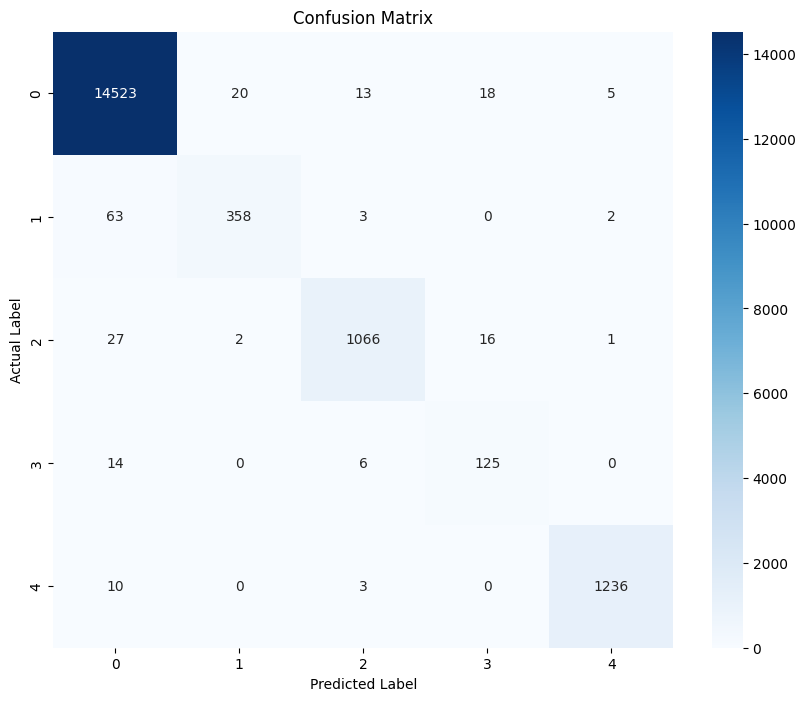

In [21]:
# Generating the confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plotting the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2, 3, 4], yticklabels=[0, 1, 2, 3, 4])
plt.title("Confusion Matrix")
plt.ylabel("Actual Label")
plt.xlabel("Predicted Label")
plt.show()